<a href="https://colab.research.google.com/github/noahjett/Movie-Goodreads-Analysis/blob/master/Book_Movie_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie & Book Reviews Project

Author: Noah Jett

Date: 11/13/2019

Made as part of Data Science 377 at Illinois Wesleyan University

This project seeks to explore two well documented datasets from popular data science site Kaggle, 'Goodreads-books' and 'TMDB 5000 Movie Dataset'. 


### Dataset 1: Goodreads-books from Kaggle
Goodreads-books is data pulled from popular book review and reccomendation site Goodreads. Each entry in this dataset is a unique book, and contains information like author, pages, average rating, and number of reviews. The data was scraped from the site directly using the publically available Goodreads API.

Can be found here:
https://www.kaggle.com/jealousleopard/goodreadsbooks



### Dataset 2: TMDB 5000 Movie Dataset from Kaggle
Data on 5000 movies scraped from The Movie Database (TMDB).

Can be found here:
https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_credits.csv



### Goal

The goal of this project is to do exploratory analyses on these datasets, combine them, and look at entries occurring in both datasets, i.e. books which have a movie adaptation. 



### Research Questions: 
1.   What is the relationship between movies based on a book, and movies not based on a book?
2. Alternatively, are books with movie adaptations rated differently than those without? How?

An important note is that merging the two datasets is itself an important goal of the project. Combining datasets can create value by allowing future data scientists to look at data in different ways, and ask different questions.


### Ethics Statement

This project uses two publically available datasets, which can be found here https://www.kaggle.com/jealousleopard/goodreadsbooks, and here https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_credits.csv.

These datasets were created through publically available APIs, and are some of the highest rated sets on the popular data science site Kaggle. They do not contain any private information on persons or compaines. The movie dataset contains information about movie budgets and revenues, both of which are publically available information. 

The result of this project, to combine the datasets and identify relationships between them, should not have any negative impact on specific works or their creators. The subjects of the datasets can realistically only gain from the information created from this project.

### Imports and setup

In [0]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth',1000)

In [2]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [0]:
import fuzzywuzzy
from fuzzywuzzy import process 

Import Method: From Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path1 = "/content/drive/My Drive/data/books.csv"
books = pd.read_csv(path1, error_bad_lines=False)

path2 = "/content/drive/My Drive/data/tmdb_5000_movies.csv"
movies = pd.read_csv(path2, error_bad_lines=False)

path3 = "/content/drive/My Drive/data/tmdb_5000_credits.csv"
credits = pd.read_csv(path3, error_bad_lines=False)

#path4 = "/content/drive/My Drive/data/Dataframe.csv"
#df = pd.read_csv(path4, error_bad_lines=False)


b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


### Missing values 

In [6]:
books.isna().sum()


bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
# num_pages           0
ratings_count         0
text_reviews_count    0
dtype: int64

Goodreads dataset has no missing values

In [7]:
movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

We see that the 'homepage' and 'tagline' fields are empty for many entries, but these are values we are not concerned with. 

There are also a few (<=3) for other fields, but since they are so few these can likely be dropped with no effect.

### Goodreads Columns/Variables



*   **title** - The name of the book
*   **authors** - The writer of the book
*   **average_rating** - From 1-5, the average rating given by reviewers
*   **language_code** - A shorthand for the language used
*   **# num_pages** - The number of pages in the book
*   **ratings_count** - The total number of reviews for the book




### Goodreads descriptives

In [8]:
books.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
0,1,Harry Potter and the Half-Blood Prince (Harry Potter #6),J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
1,2,Harry Potter and the Order of the Phoenix (Harry Potter #5),J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
2,3,Harry Potter and the Sorcerer's Stone (Harry Potter #1),J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
3,4,Harry Potter and the Chamber of Secrets (Harry Potter #2),J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
4,5,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964


### Dropping unused columns

In [0]:
books = books.drop(columns=['bookID', 'isbn', 'isbn13', 'language_code'])

In [10]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13714 entries, 0 to 13713
Data columns (total 6 columns):
title                 13714 non-null object
authors               13714 non-null object
average_rating        13714 non-null float64
# num_pages           13714 non-null int64
ratings_count         13714 non-null int64
text_reviews_count    13714 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 643.0+ KB


In [11]:
books.describe().T

,count,mean,std,min,25%,50%,75%,max
average_rating,13714.00,3.93,0.36,0.00,3.77,3.96,4.13,5.00
# num_pages,13714.00,342.40,252.65,0.00,196.00,301.00,421.00,6576.00
ratings_count,13714.00,17765.40,112957.23,0.00,83.00,630.50,4742.25,5629932.00
text_reviews_count,13714.00,533.63,2529.01,0.00,7.00,40.00,222.00,93619.00


### Movies Columns/Variables



*  **title** - The name of the movie
*  **vote_average** - From 1-10, the average score given by reviewers
*  **runtime** - Length of the movie in minutes
*  **revenue** - Money earned in USD
*  **overview** - A short description of the movie 
*  **popularity** - A metric for the movie's popularity, provided by TMDB, poorly defined
*  **keywords** - Word/phrases/names assiciated with the movie, its type/genre
*  **budget** - Budget the movie had in production in USD



### Movie descriptives

In [12]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.44,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.20,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""calypso""}, {""id"": 6155, ""name"": ""afterlife""}, {""id"": 6211, ""name"": ""fighter""}, {""id"": 12988, ""name"": ""pirate""}, {""id"": 157186, ""name"": ""swashbuckler""}, {""id"": 179430, ""name"": ""aftercreditsstinger""}]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.08,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.90,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret agent""}, {""id"": 9663, ""name"": ""sequel""}, {""id"": 14555, ""name"": ""mi6""}, {""id"": 156095, ""name"": ""british secret service""}, {""id"": 158431, ""name"

### Dropping unused movie columns

In [0]:
movies = movies.drop(columns=['genres', 'homepage', 'id', 'original_language', 'production_countries'])

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 15 columns):
budget                  4803 non-null int64
keywords                4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 563.0+ KB


In [15]:
movies.describe().T

,count,mean,std,min,25%,50%,75%,max
budget,4803.00,29045039.88,40722391.26,0.00,790000.00,15000000.00,40000000.00,380000000.00
popularity,4803.00,21.49,31.82,0.00,4.67,12.92,28.31,875.58
revenue,4803.00,82260638.65,162857100.94,0.00,0.00,19170001.00,92917187.00,2787965087.00
runtime,4801.00,106.88,22.61,0.00,94.00,103.00,118.00,338.00
vote_average,4803.00,6.09,1.19,0.00,5.60,6.20,6.80,10.00
vote_count,4803.00,690.22,1234.59,0.00,54.00,235.00,737.00,13752.00


## Overview of data transformations and merge

A significant goal of this project is to perform transformations on and merge the dataset. The final result we want is a single dataframe, whose entries are Things which are both a book and a movie, and the corresponding information for each of those.

####Failed Attempts/Techniques:



**Naive merge with Pandas**



```
pd.merge(books, movies)
```



The Pandas library provides a built in merge function, which uses relational database-like joins to combine datasets. If you give these two datasets, unmodified, to this method, it will find the shared column 'title', and merge all entries which have the same title.

There are two major problems from this:

1.   It only matches titles which are exactly the same.
2.   A book and movie might have the same title, but be different things.


**Using metadata to merge**

A potential solution which avoids these problems is to merge on some other data. The movie dataset in particular has a lot of information in the **overview** and **keywords** columns. If a movie directly mentioned the title of a book in these areas, or mentioned the author of the book in the credits, we could potentially use that information to match with the book. This method had limited success because entries had inconsistent amount of data. Some movies mentioned the books they were based on, some didn't.

However, this method was accurate enough for this dataset to be turned into a **verify()** function which checked whether a book/movie pair were actually the same thing, **solving problem 2**.

**Partial String Matching with Fuzzywuzzy to solve problem 1**

With any data entry, it is common for entries to have slight variations. The goodreads dataset shows a lot of this, with different editions and versions of the same book. For example, the most common versions of the Harry Potter novels have the form 'Harry Potter and the Sorcerers Stone (Harry Potter #1)'. This title would not match with the movie entry, which does not have the trailing part in parentheses. What we want then is to see if a title is at least xx% the same, to account for these differences.

One way to do this is to calculate the Levenshtein distance, described in more detail [here](https://en.wikipedia.org/wiki/Levenshtein_distance). One Python library which implements this is Fuzzywuzzy.




# Basic Visualizations (move/get rid of?)


### What authors have published the most books?

In [16]:
most_published_authors = books['authors'].value_counts()[:10]
mostcounts = most_published_authors.reset_index()
mostcounts


,index,authors
0,Agatha Christie,69
1,Stephen King,66
2,Orson Scott Card,48
3,Rumiko Takahashi,46
4,P.G. Wodehouse,42
5,Terry Brooks,40
6,Piers Anthony,34
7,Margaret Weis-Tracy Hickman,33
8,Dan Simmons,32
9,Gabriel García Márquez,31


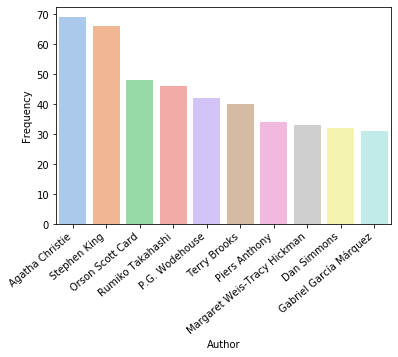

In [17]:
authorplot = sns.barplot(x = 'index',y='authors', data=mostcounts, palette="pastel")
authorplot.set_xticklabels(authorplot.get_xticklabels(), rotation=40, ha="right")
authorplot.set(xlabel='Author', ylabel='Frequency')
plt.show()

### What are the 25 highest rated books?

In [18]:
# Do with groupby?

highest_rated_all = books.sort_values('average_rating', ascending=False)[:100]
highest_rated_books = highest_rated_all[['title', 'authors', 'average_rating', 'ratings_count', 'text_reviews_count']]
highest_rated_books


,title,authors,average_rating,ratings_count,text_reviews_count
6077,The Complete Theory Fun Factory: Music Theory Puzzles and Games for the Early Grades,Ian Martin-Katie Elliott,5.00,1,0
4939,Zone of the Enders: The 2nd Runner Official Strategy Guide,Tim Bogenn,5.00,2,0
963,Literature Circle Guide: Bridge to Terabithia: Everything You Need For Successful Literature Circles That Get Kids Thinking Talking Writing—and Loving Literature,Tara MacCarthy,5.00,4,1
7506,The New Big Book of America,Todd Davis-Marc Frey,5.00,2,1
11067,Bubbles in the Middle (The Powerpuff Girls Plus You Club #16),Aaron Rosenberg-Christopher Cook,5.00,5,0
...,...,...,...,...,...
13708,The Sandman: King of Dreams,Alisa Kwitney-Neil Gaiman,4.62,12775,34
11218,Organizational Architecture: Designs for Changing Organizations,David A. Nadler-Robert B. Shaw-Marc S. Gerstein,4.62,2,0
10721,The Feynman Lectures on Physics Vol 2,Richard P. Feynman-Robert B. Leighton-Matthew L. Sands,4.61,17,2
7555,Nausicaä de la vallée du vent tome 5,Hayao Miyazaki,4.61,55,3


The above cell showed an important detail, that not all entries have the same amount of reviews

Let's see what the highest rated books with at least 100 reviews are

In [19]:
highest_with_hundred = highest_rated_all[highest_rated_all['ratings_count'] >= 100][:10]
highest_with_hundred = highest_with_hundred[['title', 'authors', 'average_rating', 'ratings_count']]

fave_cols = highest_with_hundred[['title', 'average_rating']]

highest_with_hundred

,title,authors,average_rating,ratings_count
7922,The Complete Calvin and Hobbes,Bill Watterson,4.82,31249
5,Harry Potter Boxed Set Books 1-5 (Harry Potter #1-5),J.K. Rowling-Mary GrandPré,4.78,38872
8400,It's A Magical World,Bill Watterson,4.76,138
7924,It's a Magical World (Calvin and Hobbes #11),Bill Watterson,4.76,23336
7925,The Indispensable Calvin and Hobbes,Bill Watterson,4.74,15641
7,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,27410
2182,Early Color,Saul Leiter-Martin Harrison,4.73,114
7926,Homicidal Psycho Jungle Cat (Calvin and Hobbes #9),Bill Watterson,4.72,14952
7930,Calvin and Hobbes: Sunday Pages 1985-1995: An Exhibition Catalogue,Bill Watterson,4.71,3537
12976,The Price of the Ticket: Collected Nonfiction 1948-1985,James Baldwin,4.70,396


**The world really likes Calvin and Hobbes**

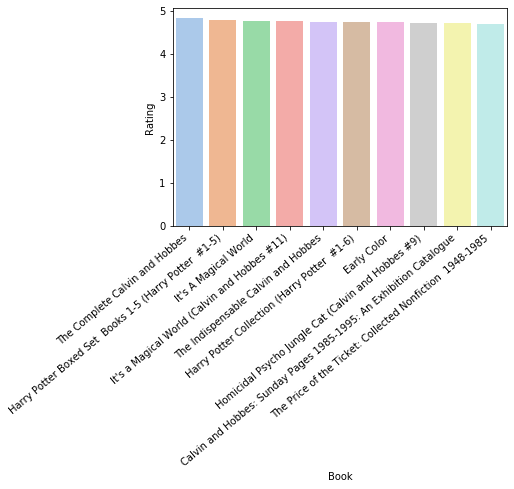

In [20]:
favebookplot = sns.barplot(x = 'title',y='average_rating', data=fave_cols, palette="pastel")
favebookplot.set_xticklabels(favebookplot.get_xticklabels(), rotation=40, ha="right")
favebookplot.set(xlabel='Book', ylabel='Rating')
plt.show()

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 15 columns):
budget                  4803 non-null int64
keywords                4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 563.0+ KB


### What are the highest budget movies?

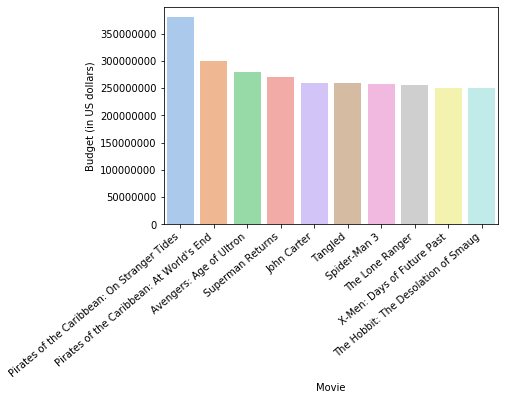

In [22]:
most_expensive_df = movies.sort_values('budget',ascending=False)[:10]

most_expensive = most_expensive_df[['title', 'budget', 'revenue']]

expensiveplot = sns.barplot(x = 'title',y='budget', data=most_expensive, palette="pastel")
expensiveplot.set_xticklabels(expensiveplot.get_xticklabels(), rotation=40, ha="right")
expensiveplot.set(xlabel='Movie', ylabel='Budget (in US dollars)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [23]:
most_expensive

,title,budget,revenue
17,Pirates of the Caribbean: On Stranger Tides,380000000,1045713802
1,Pirates of the Caribbean: At World's End,300000000,961000000
7,Avengers: Age of Ultron,280000000,1405403694
10,Superman Returns,270000000,391081192
4,John Carter,260000000,284139100
6,Tangled,260000000,591794936
5,Spider-Man 3,258000000,890871626
13,The Lone Ranger,255000000,89289910
46,X-Men: Days of Future Past,250000000,747862775
22,The Hobbit: The Desolation of Smaug,250000000,958400000


### What are the most popular movies?

In [24]:
most_popular_df = movies.sort_values('popularity',ascending=False)[:10]
most_popular = most_popular_df[['title', 'popularity', 'release_date']]
most_popular

,title,popularity,release_date
546,Minions,875.58,2015-06-17
95,Interstellar,724.25,2014-11-05
788,Deadpool,514.57,2016-02-09
94,Guardians of the Galaxy,481.10,2014-07-30
127,Mad Max: Fury Road,434.28,2015-05-13
28,Jurassic World,418.71,2015-06-09
199,Pirates of the Caribbean: The Curse of the Black Pearl,271.97,2003-07-09
82,Dawn of the Planet of the Apes,243.79,2014-06-26
200,The Hunger Games: Mockingjay - Part 1,206.23,2014-11-18
88,Big Hero 6,203.73,2014-10-24


### Old matching techniques

Now we are looking to do exact title matches.

Thinking back to the 'Hatchet' example, we can prune some values.
Can drop titles with only one word, since it is highly likely single word titles have been used repeatedly.

The below code drops 800 book rows, 1000 movie rows

I made copies of the dataset here rather than modifying the original.

In [25]:
"""
books_for_match['wordcount'] = books_for_match['title'].str.split().str.len()
books_for_match = books_for_match[books_for_match['wordcount'] > 1]
movies_for_match['wordcount'] = movies_for_match['title'].str.split().str.len()
movies_for_match = movies_for_match[movies_for_match['wordcount'] > 1]
"""

"\nbooks_for_match['wordcount'] = books_for_match['title'].str.split().str.len()\nbooks_for_match = books_for_match[books_for_match['wordcount'] > 1]\nmovies_for_match['wordcount'] = movies_for_match['title'].str.split().str.len()\nmovies_for_match = movies_for_match[movies_for_match['wordcount'] > 1]\n"

In [0]:
# try merging these two
#merge3 = pd.merge(books_for_match, movies_for_match)

#merge3.info()
#merge3.head(10);

In merged2 we combined: books and movies explicitly marked as being based on a book.
In merged3 we combined: all books and movies with titles greater than 1 word

We want to combine these without the duplicates, try pandas method 'concat'

In [0]:
#merge4 = pd.concat([merge2,merge3],sort=True).drop_duplicates().reset_index(drop=True)

#merge4.info()

#### The above dataframe merge4, is our most accurate and complete thus far. It has 520 entries, but with notable absences like the Harry Potter series. The reason for this is that the book entries have more complex titles. See below.

In [28]:
books[books['title'].str.contains('Har')]['title'][:5], ' ', movies[movies['title'].str.contains('Har')]['title'][:5]

(0       Harry Potter and the Half-Blood Prince (Harry Potter  #6)
 1    Harry Potter and the Order of the Phoenix (Harry Potter  #5)
 2        Harry Potter and the Sorcerer's Stone (Harry Potter  #1)
 3      Harry Potter and the Chamber of Secrets (Harry Potter  #2)
 4     Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
 Name: title, dtype: object,
 ' ',
 8         Harry Potter and the Half-Blood Prince
 110                                 Pearl Harbor
 113    Harry Potter and the Order of the Phoenix
 114          Harry Potter and the Goblet of Fire
 191     Harry Potter and the Prisoner of Azkaban
 Name: title, dtype: object)

Compare titles 1: O(n^2) over ~15,000 elements

    for the title of each book entry:  
     compare to the title of each movie entry:
        if titles are within acceptabe range of same:
          found match!


Look for pandas vectorized operations to do above:



# Transformations and merging

## Partial String Matching

#### **find_matches()**

This function makes use of the fuzzywuzzy library to do partial string matching, and returns all strings at least xx% the same as the input string

In [0]:
def find_matches(df, column, string_to_match, min_ratio):
    # get a list of unique strings
    #print('string_to_match',string_to_match)
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    #print('matches', matches)

    # only get matches with a ratio > min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    #print('close_matches',close_matches)
    return close_matches





In [0]:
books_slice = books[0:2000].copy()
movie_slice = movies[0:2000].copy()

Generator below enumerates through all titles to find possible matches. This brute force approach takes ~ minutes for the full datasets.

In [31]:

matches_dict = {}
# smaller_book_section works
for i in books['title']:
  tmp = find_matches(movies, column='title', string_to_match=str(i),min_ratio=70)
  if tmp != []:
    matches_dict[i] = tmp

    
# takes ~11 minutes

same_names = pd.DataFrame.from_dict(matches_dict, orient='index')
same_names = same_names.reset_index()
same_names = same_names[['index',0]]
same_names.columns = ['Book', 'Movie']

# Same names shows all of the book/movie title matches at an 80% threshold
same_names

 

,Book,Movie
0,Harry Potter and the Half-Blood Prince (Harry Potter #6),Harry Potter and the Half-Blood Prince
1,Harry Potter and the Order of the Phoenix (Harry Potter #5),Harry Potter and the Order of the Phoenix
2,Harry Potter and the Sorcerer's Stone (Harry Potter #1),Harry Potter and the Philosopher's Stone
3,Harry Potter and the Chamber of Secrets (Harry Potter #2),Harry Potter and the Chamber of Secrets
4,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),Harry Potter and the Prisoner of Azkaban
...,...,...
2150,Seeing,Se7en
2151,The Cinderella Pact,Cinderella Man
2152,Harlequin Valentine,Blue Valentine
2153,Black Orchid,Black or White


Previously we observed that there is a high likelyhood for one word titles to match, but not be the same thing. We do a second pass over one word titles, requiring a higher level of similarity to accept them as the same.

In [0]:

one_word_titles = same_names[same_names['Book'].str.split().str.len() == 1]
one_word_dict = {}
for i in one_word_titles['Book']:
  tmp = find_matches(one_word_titles, column='Movie', string_to_match=str(i),min_ratio=95)
  if tmp != []:
    one_word_dict[i] = tmp

# one_word_dict shows all one word title book/movie matches at a 90% threshold
one_word_dict
one_word_df = pd.DataFrame.from_dict(one_word_dict, orient='index')
one_word_df = one_word_df.reset_index()
one_word_df


one_word_df.columns = ['Book', 'Movie']
#one_word_df


In [33]:
# grab more than one word titles
same_names_no_ones = same_names[same_names['Book'].str.split().str.len() > 1]

# combine highly likely one-word titles and more than one word titles
same_names_final = pd.concat([same_names_no_ones, one_word_df],sort=True).reset_index(drop=True)


# *********
# Final title matched dataframe
same_names_final



,Book,Movie
0,Harry Potter and the Half-Blood Prince (Harry Potter #6),Harry Potter and the Half-Blood Prince
1,Harry Potter and the Order of the Phoenix (Harry Potter #5),Harry Potter and the Order of the Phoenix
2,Harry Potter and the Sorcerer's Stone (Harry Potter #1),Harry Potter and the Philosopher's Stone
3,Harry Potter and the Chamber of Secrets (Harry Potter #2),Harry Potter and the Chamber of Secrets
4,Harry Potter and the Prisoner of Azkaban (Harry Potter #3),Harry Potter and the Prisoner of Azkaban
...,...,...
1919,Holes,Holes
1920,After,After
1921,Thirteen,Thirteen
1922,Monster,Monster


In [0]:
same_names_final = same_names_final.reset_index()


Our same_names_final dataframe contains our partially string matched titles. If we want to do a pandas merge, they still will not merge with the same title. The easiest way to fix this is to simply set one of the titles to the other, so they are consistent

In [0]:
#same_names_final
for i in same_names_final['Book']:
  movie = same_names_final[same_names_final['Book'] == i]['Movie'].iloc[0]

  books.loc[books['title'] == i, 'title'] = movie
  same_names_final.loc[same_names_final['Movie']== movie, 'Book'] = movie


In [0]:
"""
get_data_from_names = []
for i in same_names_final['Book']:
  get = books[books['title'] == i]
  get_data_from_names.append(get.sort_values(by='ratings_count',ascending=False)[:1])
"""

book_to_list = same_names_final['Book'].tolist()
movie_to_list = same_names_final['Movie'].tolist()

get_matched_books = books[books['title'].isin(book_to_list)]
get_matched_movies = movies[movies['title'].isin(movie_to_list)]





In [37]:
# potentially unnecessary sorting step
get_matched_movies.sort_values(by='title')
get_matched_books.sort_values(by='title')
;

''

### Merge String-matched Titles

In [0]:
df = pd.merge(get_matched_books,get_matched_movies)



In [39]:
movies[movies['title'].str.contains('Harr')]

,budget,keywords,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
8,250000000,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 6333, ""name"": ""wizardry""}, {""id"": 10164, ""name"": ""apparition""}, {""id"": 10791, ""name"": ""teenage crush""}, {""id"": 12564, ""name"": ""werewolf""}]",Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he discovers an old book marked as 'Property of the Half-Blood Prince', and begins to learn more about Lord Voldemort's dark past.",98.89,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2009-07-07,933959197,153.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.40,5293
113,150000000,"[{""id"": 530, ""name"": ""prophecy""}, {""id"": 616, ""name"": ""witch""}, {""id"": 1014, ""name"": ""loss of lover""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 2630, ""name"": ""cutting the cord""}, {""id"": 3650, ""name"": ""child hero""}, {""id"": 3737, ""name"": ""dying and death""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3873, ""name"": ""sorcerer's apprentice""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 4252, ""name"": ""black magic""}, {""id"": 4959, ""name"": ""death of a friend""}, {""id"": 5147, ""name"": ""sorcery""}, {""id"": 221387, ""name"": ""occultism""}]",Harry Potter and the Order of the Phoenix,"Returning for his fifth year of study at Hogwarts, Harry is stunned to find that his warnings about the return of Lord Voldemort have been ignored. Left with no choice, Harry takes matters into his own hands, training a small group of students – dubbed 'Dumbledore's Army' – to defend themselves against the dark arts.",78.14,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2007-06-28,938212738,138.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Evil Must Be Confronted.,Harry Potter and the Order of the Phoenix,7.40,5494
114,150000000,"[{""id"": 2343, ""name"": ""magic""}, {""id"": 3737, ""name"": ""dying and death""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3873, ""name"": ""sorcerer's apprentice""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 4238, ""name"": ""chosen one""}, {""id"": 4252, ""name"": ""black magic""}, {""id"": 6271, ""name"": ""boarding school""}, {""id"": 10629, ""name"": ""vision""}, {""id"": 12380, ""name"": ""tournament""}, {""id"": 13130, ""name"": ""teenager""}, {""id"": 177912, ""name"": ""wizard""}, {""id"": 188178, ""name"": ""teenage hero""}, {""id"": 223438, ""name"": ""based on young adult novel""}]",Harry Potter and the Goblet of Fire,"Harry starts his fourth year at Hogwarts, competes in the treacherous Triwizard Tournament and faces the evil Lord Voldemort. Ron and Hermione help Harry manage the pressure – but Voldemort lurks, awaiting his chance to destroy Harry and all that he stands for.",101.25,"[{""name"": ""Patalex IV Productions Limited"", ""id"": 462}, {""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2005-11-05,895921036,157.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}]",Released,Dark And Difficult Times Lie Ahead.,Harry Potter and the Goblet of Fire,7.50,5608
191,130000000,"[{""id"": 334, ""name"": ""flying""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 2630, ""name"": ""cutting the cord""}, {""id"": 3650, ""name"": ""child hero""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3873, ""name"": ""sorcerer's apprentice""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 3904, ""name"": ""griffon""}, {""id"": 4252, ""name"": ""black magic

Now we have the title matches.

Combine with entries based on a novel.

Check for duplicates and remove.



In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1767 entries, 0 to 1766
Data columns (total 20 columns):
title                   1767 non-null object
authors                 1767 non-null object
average_rating          1767 non-null float64
# num_pages             1767 non-null int64
ratings_count           1767 non-null int64
text_reviews_count      1767 non-null int64
budget                  1767 non-null int64
keywords                1767 non-null object
original_title          1767 non-null object
overview                1767 non-null object
popularity              1767 non-null float64
production_companies    1767 non-null object
release_date            1767 non-null object
revenue                 1767 non-null int64
runtime                 1767 non-null float64
spoken_languages        1767 non-null object
status                  1767 non-null object
tagline                 1514 non-null object
vote_average            1767 non-null float64
vote_count              1767 non-null i

In [41]:
df

,title,authors,average_rating,# num_pages,ratings_count,text_reviews_count,budget,keywords,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,Harry Potter and the Half-Blood Prince,J.K. Rowling-Mary GrandPré,4.56,652,1944099,26249,250000000,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 6333, ""name"": ""wizardry""}, {""id"": 10164, ""name"": ""apparition""}, {""id"": 10791, ""name"": ""teenage crush""}, {""id"": 12564, ""name"": ""werewolf""}]",Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he discovers an old book marked as 'Property of the Half-Blood Prince', and begins to learn more about Lord Voldemort's dark past.",98.89,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2009-07-07,933959197,153.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,7.40,5293
1,Harry Potter and the Half-Blood Prince,J.K. Rowling,4.56,768,1173,72,250000000,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 6333, ""name"": ""wizardry""}, {""id"": 10164, ""name"": ""apparition""}, {""id"": 10791, ""name"": ""teenage crush""}, {""id"": 12564, ""name"": ""werewolf""}]",Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he discovers an old book marked as 'Property of the Half-Blood Prince', and begins to learn more about Lord Voldemort's dark past.",98.89,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2009-07-07,933959197,153.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,7.40,5293
2,Harry Potter and the Order of the Phoenix,J.K. Rowling-Mary GrandPré,4.49,870,1996446,27613,150000000,"[{""id"": 530, ""name"": ""prophecy""}, {""id"": 616, ""name"": ""witch""}, {""id"": 1014, ""name"": ""loss of lover""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 2630, ""name"": ""cutting the cord""}, {""id"": 3650, ""name"": ""child hero""}, {""id"": 3737, ""name"": ""dying and death""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 3873, ""name"": ""sorcerer's apprentice""}, {""id"": 3884, ""name"": ""school of witchcraft""}, {""id"": 4252, ""name"": ""black magic""}, {""id"": 4959, ""name"": ""death of a friend""}, {""id"": 5147, ""name"": ""sorcery""}, {""id"": 221387, ""name"": ""occultism""}]",Harry Potter and the Order of the Phoenix,"Returning for his fifth year of study at Hogwarts, Harry is stunned to find that his warnings about the return of Lord Voldemort have been ignored. Left with no choice, Harry takes matters into his own hands, training a small group of students – dubbed 'Dumbledore's Army' – to defend themselves against the dark arts.",78.14,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name"": ""Heyday Films"", ""id"": 7364}]",2007-06-28,938212738,138.00,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Evil Must Be Confronted.,7.40,5494
3,Harry Potter and the Philosopher's Stone,J.K. Rowling-Mary GrandPré,4.47,320,5629932,70390,125000000,"[{""id"": 616, ""name"": ""witch""}, {""id"": 1441, ""name"": ""christmas party""}, {""id"": 2343, ""name"": ""magic""}, {""id"": 2630, ""name"": ""cutting the cord""}, {""id"": 3335, ""name"": ""halloween""}, {""id"": 3650, ""name"": ""child hero""}, {""id"": 3872, ""name"": ""broom""}, {""id"": 4238, ""name"": ""chosen one""}, {""id"": 4456, ""name"": ""frog""}, {""id"": 170362, ""name"": ""fantasy world""}, {""id"": 223438, ""name"": ""based on young adult novel""}]",Harry Potter and the Philosopher's Stone,"Harry Potter has lived under the stairs at his aunt and uncle's house his whole life. But on his 11th birthday, he learns he's a 

'authors' column includes foreward writers, translators etc. The first entry is always the actual author, so grab that and make an 'author' column.

In [0]:

grab = df['authors'].str.split('-')
grab = grab.apply(lambda x: x[0])
df['author'] = grab


### Merge Credits

The TMDB dataset includes addtional information on a movies cast and cres in a dataset called 'credits'. We will use it in the verify function below

In [0]:
df = pd.merge(df, credits)

### Drop duplicates

In [0]:
grab_duplicates = df.sort_values('ratings_count', ascending=False).duplicated(['title'], keep = 'first')


In [45]:
df = df.drop(df[grab_duplicates].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1231 entries, 0 to 1772
Data columns (total 24 columns):
title                   1231 non-null object
authors                 1231 non-null object
average_rating          1231 non-null float64
# num_pages             1231 non-null int64
ratings_count           1231 non-null int64
text_reviews_count      1231 non-null int64
budget                  1231 non-null int64
keywords                1231 non-null object
original_title          1231 non-null object
overview                1231 non-null object
popularity              1231 non-null float64
production_companies    1231 non-null object
release_date            1231 non-null object
revenue                 1231 non-null int64
runtime                 1231 non-null float64
spoken_languages        1231 non-null object
status                  1231 non-null object
tagline                 1049 non-null object
vote_average            1231 non-null float64
vote_count              1231 non-null i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### Verify


Steps:
*   Does movie mention book author?
*   Look for 'based on novel' type phrase in movie: keywords, genre, credits
*   Look for reference to book in overview




Verify step 1: Does movie mention book author?

In [0]:
for i in df['title']:
  author = df[df['title'] == i]['author']
  author = author.iloc[0]
  get = df[df['title'] == i]['crew'].str.contains(f'{author}').iloc[0]
  #print(f'"{author}""')
  df.loc[df['title'] == i, 'Mentions Author'] = get



Verify step 2: Explicitly says based on novel

In [0]:
for i in df['title']:
  keyword = df[df['title'] == i]['keywords'].str.lower()
  value = keyword.str.contains('novel')
  df.loc[df['title'] == i, 'Based on Novel'] = value



Verify step 3: Look in overview for 'novel, book, authobiography'

In [0]:
for i in df['title']:
  overview = df[df['title'] == i]['overview'].str.lower()
  author = df[df['title'] == i]['author'].str.lower()

  novel = overview.str.contains('novel')
  book = overview.str.contains('book')
  best_selling = overview.str.contains('best selling')
  potter = overview.str.contains('potter')
  mentions_author = overview.str.contains(str(author))
  contains_one = novel | book | best_selling | mentions_author | potter
  df.loc[df['title'] == i, 'Overview mentions book'] = contains_one



In [0]:
def verify(df):
  df['Verify'] = df['Mentions Author'] | df['Based on Novel'] | df['Overview mentions book']



In [0]:
verify(df)

unverified = df[df['Verify'] == False]
df = df[df['Verify'] == True]


In [51]:
unverified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905 entries, 20 to 1772
Data columns (total 28 columns):
title                     905 non-null object
authors                   905 non-null object
average_rating            905 non-null float64
# num_pages               905 non-null int64
ratings_count             905 non-null int64
text_reviews_count        905 non-null int64
budget                    905 non-null int64
keywords                  905 non-null object
original_title            905 non-null object
overview                  905 non-null object
popularity                905 non-null float64
production_companies      905 non-null object
release_date              905 non-null object
revenue                   905 non-null int64
runtime                   905 non-null float64
spoken_languages          905 non-null object
status                    905 non-null object
tagline                   768 non-null object
vote_average              905 non-null float64
vote_count          

# Merged Set 



In [0]:
df = df.rename(columns={'average_rating': 'book_rating', 'vote_average': 'movie_rating'})


Utility function for saving df to drive

In [0]:
def save_df(df):
  dataframe_csv = df.to_csv()
  with open("/content/drive/My Drive/data/Dataframe.csv", 'w') as f:
    f.write(dataframe_csv)


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326 entries, 0 to 1766
Data columns (total 28 columns):
title                     326 non-null object
authors                   326 non-null object
book_rating               326 non-null float64
# num_pages               326 non-null int64
ratings_count             326 non-null int64
text_reviews_count        326 non-null int64
budget                    326 non-null int64
keywords                  326 non-null object
original_title            326 non-null object
overview                  326 non-null object
popularity                326 non-null float64
production_companies      326 non-null object
release_date              326 non-null object
revenue                   326 non-null int64
runtime                   326 non-null float64
spoken_languages          326 non-null object
status                    326 non-null object
tagline                   281 non-null object
movie_rating              326 non-null float64
vote_count           

In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,326.00,3.94,0.25,2.86,3.80,3.96,4.10,4.56
# num_pages,326.00,333.96,202.64,1.00,211.00,303.50,418.25,1463.00
ratings_count,326.00,177326.98,457442.85,2.00,1392.25,15072.00,159474.75,5629932.00
text_reviews_count,326.00,4153.71,9674.73,0.00,94.00,848.50,3472.25,84237.00
budget,326.00,40125102.94,45849453.26,0.00,7050000.00,25000000.00,60000000.00,250000000.00
popularity,326.00,30.04,29.44,0.02,9.37,21.10,42.57,167.93
revenue,326.00,132691983.58,212837541.87,0.00,9355599.00,49848044.50,150765877.25,1118888979.00
runtime,326.00,118.99,24.85,75.00,101.00,115.00,131.00,242.00
movie_rating,326.00,6.61,0.80,4.40,6.10,6.70,7.20,8.40
vote_count,326.00,1128.04,1667.59,1.00,130.25,482.50,1291.25,9413.00


In [57]:
df['title'].unique()

array(['Harry Potter and the Half-Blood Prince',
       'Harry Potter and the Order of the Phoenix',
       "Harry Potter and the Philosopher's Stone",
       'Harry Potter and the Chamber of Secrets',
       'Harry Potter and the Prisoner of Azkaban',
       "The Hitchhiker's Guide to the Galaxy",
       'The Lord of the Rings: The Fellowship of the Ring',
       'The Lord of the Rings: The Two Towers',
       'The Count of Monte Cristo',
       "What to Expect When You're Expecting", 'Anna Karenina',
       'Treasure Planet', 'The Wedding Date', 'The Namesake',
       'Paper Towns', 'The Lovely Bones', 'Atlas Shrugged Part II',
       'The Living Wake', 'The Big Year', 'The Kite Runner',
       'Memoirs of a Geisha', 'Angels & Demons', 'The Da Vinci Code',
       'Snow Flower and the Secret Fan', 'Life of Pi',
       'The Clan of the Cave Bear', 'Warm Bodies', 'The Great Raid',
       'The Princess and the Frog', 'Hamlet', 'Veronika Decides to Die',
       'Brokeback Mountain', 'The 

We have the books which have movies, grab those that don't, store in datafraem called just_books

In [0]:
just_books = books[~books['title'].isin(df['title'])]

books['Made into movie'] = books['title'].isin(df['title'])

In [60]:
just_books = just_books.rename(columns={'average_rating': 'book_rating'})

just_books.describe()
df.describe()

,book_rating,# num_pages,ratings_count,text_reviews_count,budget,popularity,revenue,runtime,movie_rating,vote_count,movie_id
count,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00,326.00
mean,3.94,333.96,177326.98,4153.71,40125102.94,30.04,132691983.58,118.99,6.61,1128.04,32385.80
std,0.25,202.64,457442.85,9674.73,45849453.26,29.44,212837541.87,24.85,0.80,1667.59,61891.52
min,2.86,1.00,2.00,0.00,0.00,0.02,0.00,75.00,4.40,1.00,66.00
25%,3.80,211.00,1392.25,94.00,7050000.00,9.37,9355599.00,101.00,6.10,130.25,2168.25
50%,3.96,303.50,15072.00,848.50,25000000.00,21.10,49848044.50,115.00,6.70,482.50,10547.00
75%,4.10,418.25,159474.75,3472.25,60000000.00,42.57,150765877.25,131.00,7.20,1291.25,25916.75
max,4.56,1463.00,5629932.00,84237.00,250000000.00,167.93,1118888979.00,242.00,8.40,9413.00,339984.00


### Combined rating
Books on goodreads are rated out out of 5.

Movies are rated out of 10

In comparing a book+movie combination it would make sense to have a total rating that fairly weighs the two scores. For now I am multiplying the book rating by 2, adding it to the movie score, dividing the total by 2.

In [61]:
df['Combined Rating'] = ((df['book_rating'] * 2)  + df['movie_rating']) / 2
print('Highest combined rating')
df.sort_values('Combined Rating', ascending=False)[:10][['title','Combined Rating']]

Highest combined rating


,title,Combined Rating
633,Howl's Moving Castle,8.61
1305,The Godfather,8.57
952,The Green Mile,8.54
19,The Lord of the Rings: The Two Towers,8.53
704,The Lord of the Rings: The Return of the King,8.51
11,The Lord of the Rings: The Fellowship of the Ring,8.49
7,Harry Potter and the Prisoner of Azkaban,8.40
589,Fight Club,8.35
771,Anne of Green Gables,8.34
1711,Harry Potter and the Goblet of Fire,8.30


In [62]:
print('Lowest combined rating')
df.sort_values('Combined Rating', ascending=True)[:10][['title','Combined Rating']]

Lowest combined rating


,title,Combined Rating
842,The Informers,5.58
1252,Confessions of a Teenage Drama Queen,5.87
736,Gulliver's Travels,6.01
1488,The Island of Dr. Moreau,6.02
1082,Under the Rainbow,6.04
1034,Striptease,6.04
109,The Big Year,6.05
1608,Damnation Alley,6.07
729,Congo,6.08
389,The Extra Man,6.10


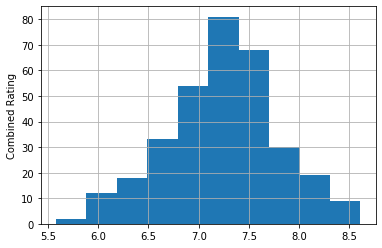

In [63]:
df['Combined Rating'].hist()
plt.ylabel('Combined Rating')
plt.show()

In [64]:
df.corr()['Combined Rating'].abs().sort_values(ascending=False)

Combined Rating          1.00
movie_rating             0.92
book_rating              0.76
popularity               0.49
vote_count               0.48
runtime                  0.41
revenue                  0.31
ratings_count            0.24
text_reviews_count       0.19
# num_pages              0.12
Mentions Author          0.09
budget                   0.07
Based on Novel           0.05
movie_id                 0.04
Overview mentions book   0.01
Verify                    nan
Name: Combined Rating, dtype: float64

In [65]:
df.corr()['book_rating'].abs().sort_values(ascending=False)

book_rating              1.00
Combined Rating          0.76
movie_rating             0.44
popularity               0.32
vote_count               0.31
ratings_count            0.30
runtime                  0.29
revenue                  0.28
text_reviews_count       0.24
budget                   0.17
# num_pages              0.16
Based on Novel           0.10
Mentions Author          0.06
movie_id                 0.03
Overview mentions book   0.01
Verify                    nan
Name: book_rating, dtype: float64

In [66]:
df.corr()['movie_rating'].abs().sort_values(ascending=False)

movie_rating             1.00
Combined Rating          0.92
popularity               0.48
vote_count               0.48
book_rating              0.44
runtime                  0.40
revenue                  0.26
ratings_count            0.14
text_reviews_count       0.11
Mentions Author          0.08
# num_pages              0.06
movie_id                 0.04
budget                   0.01
Overview mentions book   0.01
Based on Novel           0.00
Verify                    nan
Name: movie_rating, dtype: float64

In [0]:
from sklearn.linear_model import LinearRegression

### Can we use linear regression to predict what a book's movie rating would be?

In [0]:
# to predict combined rating
features = df[['book_rating', 'ratings_count']]

outcome = df['movie_rating']

movie_rating_regression = LinearRegression().fit(features, outcome)


In [69]:
print("This model's r-squared is:", movie_rating_regression.score(features,outcome).round(2))



This model's r-squared is: 0.19


In [70]:
print('The predicted combined rating with these ratings is: ', movie_rating_regression.predict([[4, 1000]]).round(2))

The predicted combined rating with these ratings is:  [6.68]


In [71]:
grab1 = df[(df['book_rating'] > 3.9) & (df['book_rating'] < 4.1) & (df['ratings_count'] > 800) & (df['ratings_count'] < 1200)]

grab1[['book_rating', 'movie_rating', 'ratings_count']]

,book_rating,movie_rating,ratings_count
432,3.94,7.00,802
706,3.91,6.30,980
864,4.07,5.60,1106
1478,3.99,7.00,965


What do books that make good movies have in common?

Books that make bad ones?

How long do books with movie adaptations tend to be?

Regression that predicts if book will be amde into a movie

Notes:
Logistic regression used to find predictors for classifications



In [72]:
good = df[df['Combined Rating'] > 7]
good.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,223.00,4.04,0.19,3.57,3.92,4.03,4.16,4.56
# num_pages,223.00,341.36,210.83,1.00,216.00,320.00,438.00,1463.00
ratings_count,223.00,222486.79,532947.83,2.00,1793.00,18462.00,202937.00,5629932.00
text_reviews_count,223.00,5000.15,11020.80,0.00,95.00,877.00,3880.50,84237.00
budget,223.00,42133027.02,48839972.06,0.00,7500000.00,25000000.00,60000000.00,250000000.00
popularity,223.00,36.69,31.95,0.02,13.30,26.95,49.61,167.93
revenue,223.00,161664176.21,239246231.51,0.00,15597993.00,74787599.00,172306754.50,1118888979.00
runtime,223.00,123.34,26.95,75.00,102.50,119.00,136.00,242.00
movie_rating,223.00,7.00,0.56,5.40,6.60,7.00,7.40,8.40
vote_count,223.00,1453.61,1858.59,3.00,230.50,708.00,1736.00,9413.00


In [73]:
bad = df[df['Combined Rating'] < 7]
bad.describe().T


,count,mean,std,min,25%,50%,75%,max
book_rating,99.00,3.73,0.22,2.86,3.59,3.75,3.88,4.17
# num_pages,99.00,318.84,182.99,6.00,209.00,291.00,358.50,1168.00
ratings_count,99.00,82425.48,188749.38,3.00,836.50,9202.00,76054.00,1309623.00
text_reviews_count,99.00,2397.83,5472.45,0.00,92.00,558.00,2592.00,47291.00
budget,99.00,36602207.39,38886699.94,0.00,7100000.00,25000000.00,52500000.00,215000000.00
popularity,99.00,15.73,15.44,0.17,4.74,11.11,24.00,89.87
revenue,99.00,71292897.43,119957522.18,0.00,364384.00,27053815.00,86791596.50,752215857.00
runtime,99.00,109.66,16.11,84.00,98.00,109.00,118.00,172.00
movie_rating,99.00,5.73,0.52,4.40,5.40,5.80,6.10,6.90
vote_count,99.00,429.77,794.20,1.00,45.00,173.00,547.00,6586.00


Want to predict if book will be made into movie. Put boolean 'made into movie' column in books dataframe. Logistic regression?

In [74]:
books.corr()['Made into movie'].abs().sort_values(ascending=False)

Made into movie      1.00
text_reviews_count   0.15
ratings_count        0.15
average_rating       0.01
# num_pages          0.00
Name: Made into movie, dtype: float64

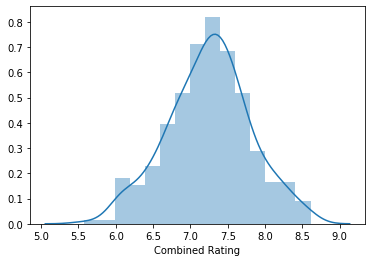

In [75]:
sns.distplot(df['Combined Rating'])

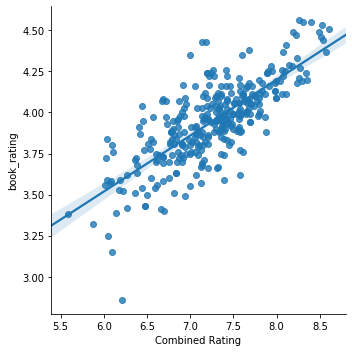

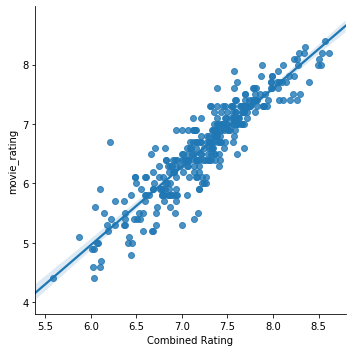

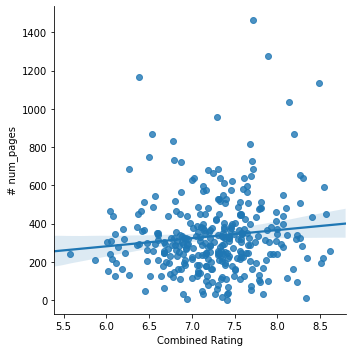

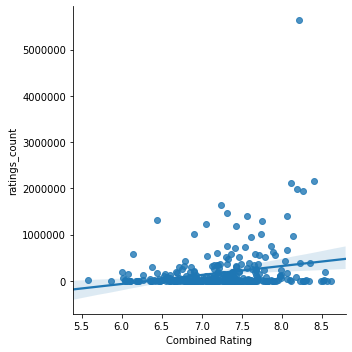

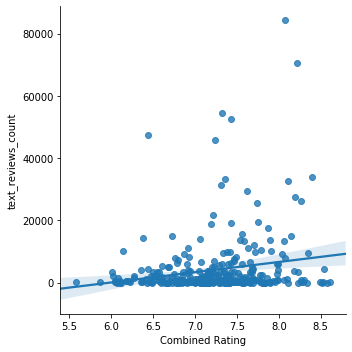

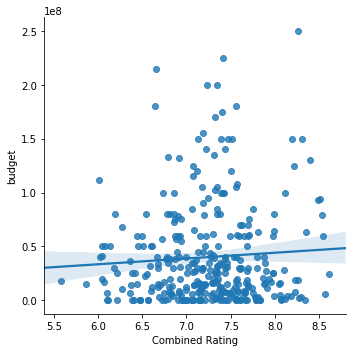

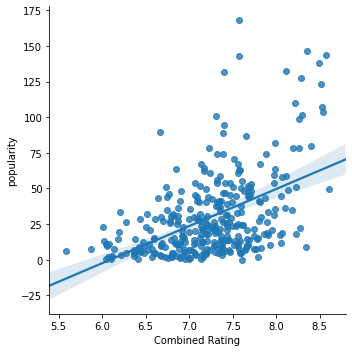

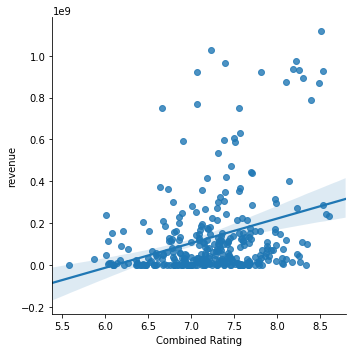

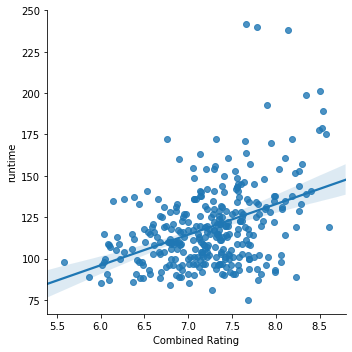

In [76]:
interesting_cols = ['book_rating', 'movie_rating', '# num_pages', 'ratings_count', 'text_reviews_count', 'budget', 'popularity', 'revenue', 'runtime']
for i in interesting_cols:
  sns.lmplot(x='Combined Rating', y=i, data=df)

###T test to determine if difference in means between movie-books and non-movie books is significant. 
Two tailed, independent

Following this guide https://pythonfordatascience.org/independent-t-test-python/



In [0]:
from scipy import stats


####Assumptions:

1. Equal variance
* Levene Test
* Bartlett Test

Normally distributed:
* Kind of

In [79]:
# levene's test for homogenity of variance
stats.levene(df['book_rating'], just_books['book_rating'])

LeveneResult(statistic=9.78319496438978, pvalue=0.0017648998990131596)

In [80]:
stats.bartlett(df['book_rating'], just_books['book_rating'])

BartlettResult(statistic=71.33512807939051, pvalue=3.014212917754956e-17)

Tiny p-value, we reject the null hypothesis of equal variance. Conclude that our samples have different variance.



(3.929766803840863, <matplotlib.axes._subplots.AxesSubplot at 0x7f29c0737cc0>)

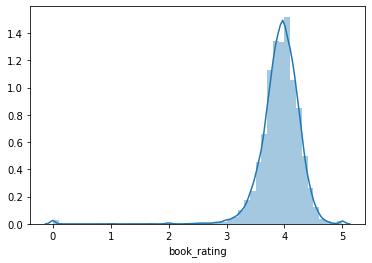

In [81]:
just_books['book_rating'].mean(), sns.distplot(just_books['book_rating'])

(3.9433435582822094, <matplotlib.axes._subplots.AxesSubplot at 0x7f29c02035f8>)

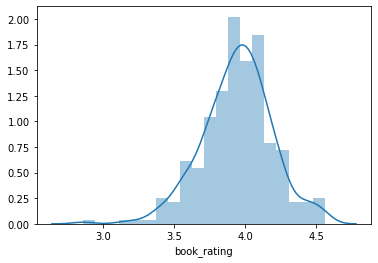

In [82]:
df['book_rating'].mean(), sns.distplot(df['book_rating'])

In [0]:
diff = df['book_rating'] - just_books['book_rating']

((array([-3.87786126, -3.65639293, -3.53497198, ...,  3.53497198,
          3.65639293,  3.87786126]),
  array([-1.15, -1.08, -0.94, ...,   nan,   nan,   nan])),
 (nan, nan, nan))

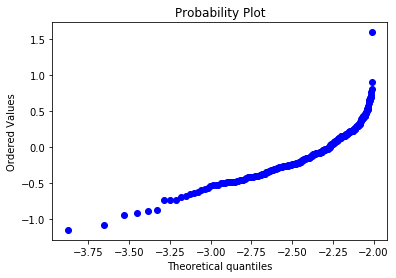

In [84]:
stats.probplot(diff, plot= plt)


Welch's T-test may work for unequal variance

In [85]:
stats.ttest_ind(df['book_rating'], just_books['book_rating'], equal_var=False)

Ttest_indResult(statistic=0.9611519252322183, pvalue=0.33712069660557586)

The test returned a pvalue of 0.337. If I am interpreting that correctly, then we can not reject the null hypothesis, which says there is no difference between the true averages of the groups. We conclude the average ratings between books which are made into movies, and those which are not, is NOT significantly different. 

### What were the best books that made the worst movies?

Books which were much better than the movie.

In [86]:
df['rating_difference'] = (df['book_rating'] * 2) - df['movie_rating']

df.sort_values(by='rating_difference', ascending=False)[['title', 'book_rating', 'movie_rating', 'rating_difference']][:10]

,title,book_rating,movie_rating,rating_difference
1087,The Bridge of San Luis Rey,4.43,5.40,3.46
1085,One for the Money,4.35,5.30,3.40
221,Pride and Prejudice and Zombies,4.43,5.50,3.36
138,The Clan of the Cave Bear,4.04,4.80,3.28
1034,Striptease,3.84,4.40,3.28
1755,Jekyll and Hyde ... Together Again,3.80,4.60,3.00
513,Breakfast of Champions,4.08,5.20,2.96
1757,The Musketeer,4.07,5.20,2.94
1633,The Big Bounce,3.95,5.00,2.90
1488,The Island of Dr. Moreau,3.72,4.60,2.84


Movies which were much better than the book.

In [87]:
df.sort_values(by='rating_difference', ascending=True)[['title', 'book_rating', 'movie_rating', 'rating_difference']][:10]

,title,book_rating,movie_rating,rating_difference
1520,Up in the Air,2.86,6.70,-0.98
1033,Gone Girl,3.62,7.90,-0.66
840,The Fault in Our Stars,3.59,7.60,-0.42
1048,The Prestige,3.88,8.00,-0.24
1355,The Notebook,3.76,7.70,-0.18
1666,The Martian,3.77,7.60,-0.06
345,The Revenant,3.66,7.30,0.02
475,The Raid,3.67,7.30,0.04
391,Stranger Than Fiction,3.57,7.10,0.04
270,Moby Dick,3.49,6.90,0.08
